## Auto ARIMA

In [1]:
from pmdarima import auto_arima, AutoARIMA
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rcParams
from pmdarima.arima import ADFTest 
from statsmodels.tools.eval_measures import rmse
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.arima import OCSBTest, ADFTest, ndiffs
from shutil import copy2
import warnings
%matplotlib inline

# Matplotlib options
rcParams['figure.figsize'] = (10, 8)
rcParams['axes.grid'] = False
plt.style.use('seaborn-deep')

# Pandas setup
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_colwidth', -1) 

warnings.filterwarnings('ignore')

In [21]:
# Read file
path = "./datasets/"
name = "p2"

df = pd.read_csv(path + name + "_clipped.csv", encoding='utf8', parse_dates=True, index_col="DATE")
validation = pd.read_csv(path + name + "_validation.csv", encoding='utf8', parse_dates=True, index_col="DATE")

cols = df.columns
col = cols[0]
series = df[col]

In [11]:
cols[0]

&#39;DQO&#39;

## Verificação de Estacionareidade pelo teste ADF (Augmented Dickey-Fuller) e Número de Diferenciações por KPSS (Kwiatkowski – Phillips – Schmidt – Shin)

In [22]:
adf_test = ADFTest(alpha = 0.05)
adf = pd.DataFrame()
diff = pd.DataFrame()

for c in cols:
    adf[c] = adf_test.should_diff(df[c])
    diff[c] = [ndiffs(df[c], alpha=.05, test='kpss', max_d=2)]

adf = adf.T.rename(columns = {0: "adf_pval", 1: "stationary"})
diff = diff.T.rename(columns = {0: "d"})
diff = diff.T
adf = adf.T
adf = adf.append(diff)
adf

,DQO,COLIFORMES_TERMOTOLERANTES,FÓSFORO,NITROGÊNIO,DBO,PH,SURFACTANTES,SÓLIDOS,ÓLEOS,COR_VERDADEIRA
adf_pval,0.023624,0.043021,0.01,0.0381,0.01,0.014383,0.032542,0.490253,0.083356,0.095539
stationary,0.000000,0.000000,0.00,0.0000,0.00,0.000000,0.000000,1.000000,1.000000,1.000000
d,0.000000,1.000000,1.00,0.0000,0.00,0.000000,1.000000,0.000000,0.000000,1.000000


## Validação
Para executar a validação vamos realizar fit em todo o conjunto disponível de dados e verificar a aproximação com os dados de validação da série histórica.

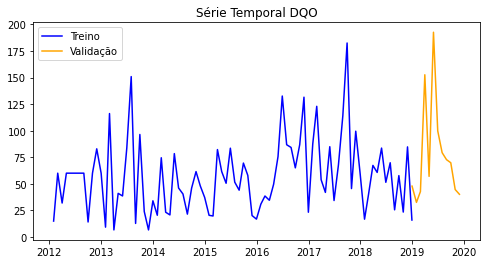

In [24]:
# train/test split
train = series 
test = validation[col]

# plot figures
plt.figure(figsize=(8, 4))
plt.plot(train, color="blue", label="Treino")
plt.plot(test, color="orange", label="Validação")
plt.legend(loc="upper left");
plt.title(f"Série Temporal {col}");

In [26]:
arima_model = auto_arima(
    train,
    start_p=0,
    d=int(adf[col].d),
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    m=12,
    seasonal=True,
    error_action='warn',
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    random_state=42,
    n_fits=50,
    maxiter=50,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=766.267, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=749.065, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=764.272, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=767.035, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=743.694, Time=2.15 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=737.600, Time=4.20 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=739.423, Time=7.38 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=739.426, Time=6.60 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=735.660, Time=2.55 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=742.057, Time=1.44 sec
 ARIMA(0,0,0)(4,1,0)[12] intercept   : AIC=737.466, Time=6.37 sec
 ARIMA(0,0,0)(3,1,1)[12] intercept   : AIC=737

In [27]:
print(arima_model.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   84
Model:             SARIMAX(3, 1, 0, 12)   Log Likelihood                -362.830
Date:                  Tue, 06 Oct 2020   AIC                            735.660
Time:                          09:50:00   BIC                            747.044
Sample:                               0   HQIC                           740.192
                                   - 84                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P&gt;|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.0027      6.031      1.990      0.047       0.183      23.823
ar.S.L12      -0.8676      0.110     -7.921      0.000      -1.082      -0.653
ar.S.L24      -0.6953      0.151 

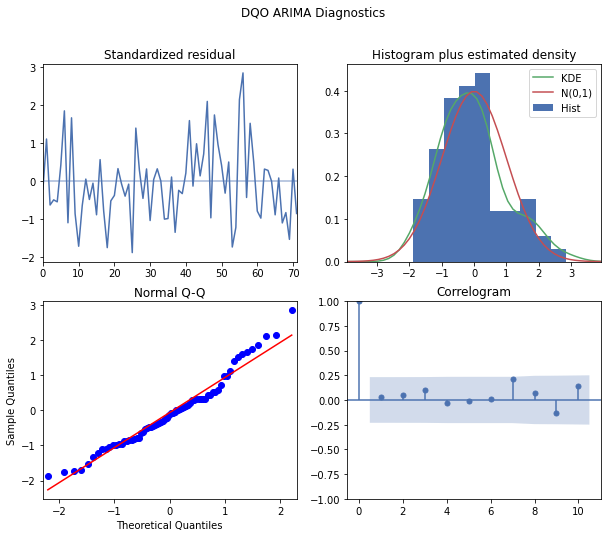

In [28]:
arima_model.plot_diagnostics()
plt.suptitle(f"{col} ARIMA Diagnostics");

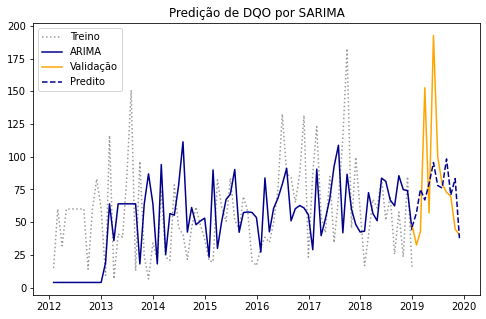

In [35]:
fitted = pd.Series(arima_model.arima_res_.fittedvalues, index=train.index)
prediction = pd.DataFrame()
prediction = pd.DataFrame(arima_model.predict(n_periods=len(validation)), index=test.index)
prediction.columns = ['predicted']

plt.figure(figsize=(8, 5))
plt.plot(train, color="grey", linestyle=":", alpha=0.8, label="Treino")
plt.plot(fitted, color="darkblue", label="ARIMA")
plt.plot(test, color="orange", label="Validação")
plt.plot(prediction, linestyle="--", color="darkblue", label="Predito")
plt.title(f"Predição de {col} por SARIMA")
plt.legend(loc="upper left");

### Modelo 2 -- ARIMA com Transformação de Box-Cox

In [9]:
from sklearn.preprocessing import PowerTransformer 

scaler = PowerTransformer(method="box-cox")
series_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

In [10]:
arima_scaled = auto_arima(
    series_scaled,
    start_p=0,
    d=int(adf[col].d),
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    m=12,
    seasonal=True,
    error_action='warn',
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    random_state=42,
    n_fits=50,
    maxiter=50,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=289.874, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=255.949, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=276.438, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=251.619, Time=0.34 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=250.712, Time=1.07 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=252.518, Time=1.87 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=5.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=11.97 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=272.754, Time=0.92 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=240.035, Time=1.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=239.171, Time=0.85 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=243.848, Time=0.16 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=240.2

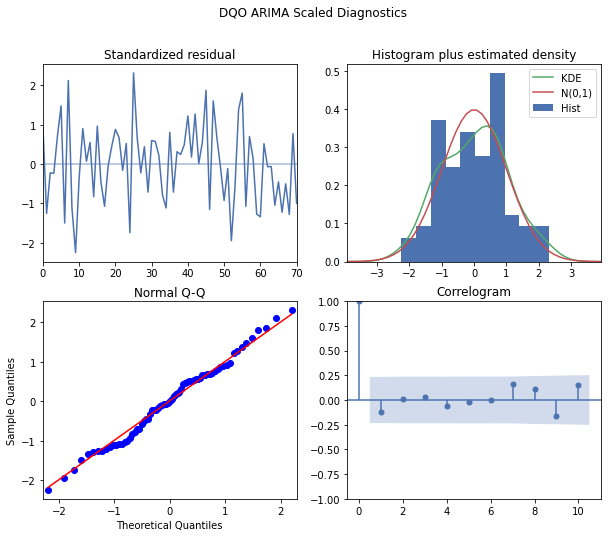

In [36]:
arima_scaled.plot_diagnostics()
plt.suptitle(f"{col} ARIMA Scaled Diagnostics");

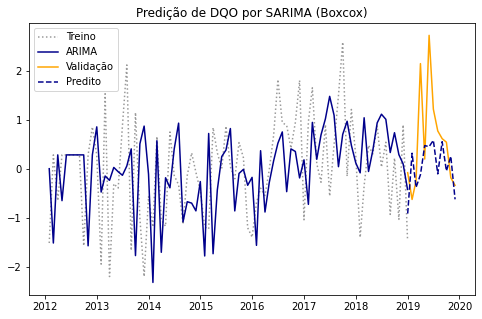

In [37]:
scale_fitted = pd.Series(arima_scaled.arima_res_.fittedvalues, index=train.index)
prediction_scaled = pd.DataFrame()
prediction_scaled = arima_scaled.predict(n_periods=len(validation))
prediction_scaled_series = pd.Series(prediction_scaled, index=test.index)
prediction_scaled_series.columns = ['predicted']
series_scaled_idx = pd.Series(series_scaled.reshape(1, -1)[0], index=train.index)
test_scaled_idx = pd.Series(scaler.transform(test.values.reshape(-1, 1)).reshape(1, -1)[0], index=test.index)

plt.figure(figsize=(8, 5))
plt.plot(series_scaled_idx, color="grey", linestyle=":", alpha=0.8, label="Treino")
plt.plot(scale_fitted, color="darkblue", label="ARIMA")
plt.plot(test_scaled_idx, color="orange", label="Validação")
plt.plot(prediction_scaled_series, linestyle="--", color="darkblue", label="Predito")
plt.title(f"Predição de {col} por SARIMA (Boxcox)")
plt.legend(loc="upper left");

In [14]:
inverted_prediction = scaler.inverse_transform(prediction_scaled.reshape(-1, 1))
inverted_prediction_series = pd.Series(inverted_prediction.reshape(1, -1)[0], index=test.index)

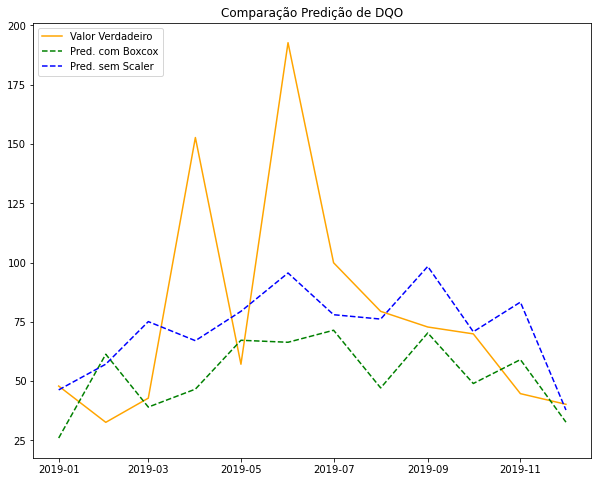

In [38]:
plt.plot(test, color="orange", label="Valor Verdadeiro")
plt.plot(inverted_prediction_series, linestyle="--", color="green", label="Pred. com Boxcox")
plt.plot(prediction, linestyle="--", color="blue", label="Pred. sem Scaler")
plt.title(f"Comparação Predição de {col}")
plt.legend(loc="upper left");

In [49]:
metrics_df = pd.DataFrame({
    "sarima": round(rmse(test, prediction.values.flatten()), 3),
    "boxcox_sarima": round(rmse(test, inverted_prediction_series), 3)
}, index=["RMSE"])
metrics_df = metrics_df.T.sort_values("RMSE")
best_fit_name = metrics_df.reset_index()['index'][0]
metrics_df

,RMSE
sarima,42.383
boxcox_sarima,50.990


In [57]:
boxcox_sarima = inverted_prediction_series
boxcox_sarima.name = col 
sarima = pd.Series(prediction['predicted'], index=validation.index)
sarima.name = col
arima = eval(best_fit_name)
%store arima

Stored &#39;arima&#39; (Series)


In [19]:
copy2("arima.ipynb", f"./models/arima/{name}_{col}.ipynb")